# Data Augmentation

In [1]:
import tensorflow.keras as keras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Steps 1, 2, 3 as before

In [3]:
# Load in our data from CSV files
train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate out our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape the data for CNN
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)

## 4. Create the model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

2022-07-03 10:32:11.213080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 4b. Data Augmentation (new!)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
) 

the `ImageDataGenerator` batches the data

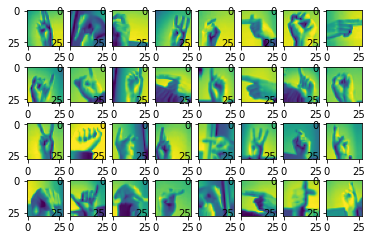

In [6]:
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [7]:
# fit data to the generator

datagen.fit(x_train)

In [8]:
# compile the model

model.compile(loss='categorical_crossentropy', 
             metrics=['accuracy'])

## 5. Train/fit the model

In [9]:
history = model.fit(img_iter,
          epochs=20,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/20
857/857 [==============================] - 43s 49ms/step - loss: 1.0914 - accuracy: 0.6513 - val_loss: 0.4257 - val_accuracy: 0.8385
Epoch 2/20
857/857 [==============================] - 42s 49ms/step - loss: 0.3104 - accuracy: 0.8950 - val_loss: 0.2058 - val_accuracy: 0.9265
Epoch 3/20
857/857 [==============================] - 47s 55ms/step - loss: 0.1982 - accuracy: 0.9333 - val_loss: 0.5987 - val_accuracy: 0.8447
Epoch 4/20
857/857 [==============================] - 46s 54ms/step - loss: 0.1559 - accuracy: 0.9487 - val_loss: 0.1824 - val_accuracy: 0.9378
Epoch 5/20
857/857 [==============================] - 47s 54ms/step - loss: 0.1302 - accuracy: 0.9585 - val_loss: 0.0879 - val_accuracy: 0.9665
Epoch 6/20
857/857 [==============================] - 44s 51ms/step - loss: 0.1115 - accuracy: 0.9649 - val_loss: 1.0009 - val_accuracy: 0.8176
Epoch 7/20
857/857 [==============================] - 46s 54ms/step - loss: 0.1014 - accuracy: 0.9696 - val_loss: 0.0442 - val_accuracy:

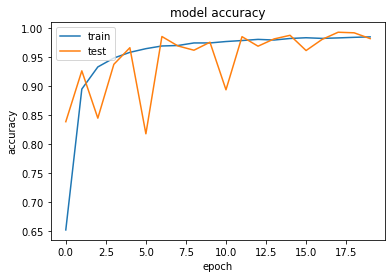

In [10]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

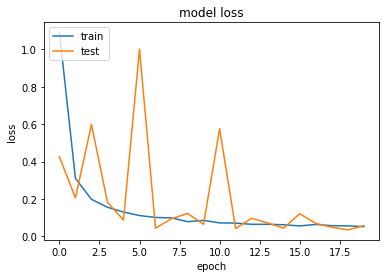

In [11]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 5b. Save the model (new!)

In [12]:
model.save('asl_model')

INFO:tensorflow:Assets written to: asl_model/assets


INFO:tensorflow:Assets written to: asl_model/assets
